# Decision Tree

In [58]:
# 1. Importing Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import mode
import time

# Set visualization style
sns.set_style("whitegrid")

In [59]:
# --- 2. Data Preparation and Preprocessing ---

# Load the dataset
try:
    df = pd.read_csv('./creditcard.csv')
except FileNotFoundError:
    print("Error: 'creditcard.csv' not found. Please check the file path.")
    exit()

# Scale 'Time' and 'Amount' features using RobustScaler
rob_scaler = RobustScaler()
df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1, 1))
df.drop(['Time', 'Amount'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', df.pop('scaled_amount'))
df.insert(1, 'scaled_time', df.pop('scaled_time'))

print("Data preprocessing complete.")
print("-" * 60)

Data preprocessing complete.
------------------------------------------------------------


In [60]:
# --- 3. Splitting the Original Data for Final Evaluation ---
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
train_df = pd.concat([X_train, y_train], axis=1)


In [61]:
# --- 4. Dynamic Feature Selection for Outlier Removal ---
temp_fraud_df = train_df[train_df['Class'] == 1]
temp_non_fraud_df = train_df[train_df['Class'] == 0].sample(n=len(temp_fraud_df), random_state=42)
temp_balanced_df = pd.concat([temp_fraud_df, temp_non_fraud_df])

corr_matrix = temp_balanced_df.corr()
class_corr = corr_matrix['Class'].drop('Class').sort_values(ascending=True)
features_to_prune = class_corr.head(3).index.tolist()

print(f"Dynamically selected features for outlier removal: {features_to_prune}")
print("-" * 60)


Dynamically selected features for outlier removal: ['V14', 'V12', 'V10']
------------------------------------------------------------


In [62]:
# --- 5. Creating Multiple Undersampled Datasets ---
# Using a larger number of datasets for a more robust ensemble.
# This number can be adjusted based on desired stability vs. computation time.
n_datasets = 50
undersampled_datasets = []
print(f"Creating {n_datasets} undersampled datasets...")

fraud_df = train_df[train_df['Class'] == 1]
non_fraud_df = train_df[train_df['Class'] == 0]

for i in range(n_datasets):
    non_fraud_sample = non_fraud_df.sample(n=len(fraud_df), random_state=42 + i)
    balanced_df = pd.concat([fraud_df, non_fraud_sample])
    
    for feature in features_to_prune:
        fraud_feature_values = balanced_df[feature].loc[balanced_df['Class'] == 1].values
        q25, q75 = np.percentile(fraud_feature_values, 25), np.percentile(fraud_feature_values, 75)
        iqr = q75 - q25
        cut_off = iqr * 1.5
        lower_bound, upper_bound = q25 - cut_off, q75 + cut_off
        balanced_df = balanced_df.drop(balanced_df[(balanced_df[feature] > upper_bound) | (balanced_df[feature] < lower_bound)].index)

    undersampled_datasets.append(balanced_df)

print(f"All {n_datasets} datasets created.")
print("-" * 60)

Creating 50 undersampled datasets...
All 50 datasets created.
------------------------------------------------------------


In [63]:
# --- 6. Model Training and Evaluation ---
start_time = time.time()

# Define models to evaluate
models_to_evaluate = {
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'BaggingClassifier': BaggingClassifier(
        estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42, n_jobs=-1
    )
}

final_predictions = {}

# a) Baseline: Train each model type on a SINGLE undersampled dataset
print("--- Training Baseline Models on a Single Undersampled Dataset ---")
single_train_df = undersampled_datasets[0]
X_train_single = single_train_df.drop('Class', axis=1)
y_train_single = single_train_df['Class']

for model_name, model in models_to_evaluate.items():
    print(f"Training '{model_name}' on a single dataset...")
    model.fit(X_train_single, y_train_single)
    y_pred_single = model.predict(X_test)
    final_predictions[f'{model_name}_Single_Dataset'] = y_pred_single

# b) VOTING ENSEMBLE: Train each model type on MULTIPLE undersampled datasets and aggregate
print("\n--- Training Voting Ensembles on Multiple Undersampled Datasets ---")
for model_name, model in models_to_evaluate.items():
    print(f"Training '{model_name}' on {n_datasets} datasets...")
    predictions_list = []
    
    for i, dataset in enumerate(undersampled_datasets):
        X_train_sample = dataset.drop('Class', axis=1)
        y_train_sample = dataset['Class']
        model.fit(X_train_sample, y_train_sample)
        y_pred = model.predict(X_test)
        predictions_list.append(y_pred)
    
    predictions_array = np.array(predictions_list)
    majority_vote_preds, _ = mode(predictions_array, axis=0)
    final_predictions[f'{model_name}_Voting_Ensemble'] = majority_vote_preds.flatten()

end_time = time.time()
print(f"\nTotal training and prediction time: {end_time - start_time:.2f} seconds")
print("-" * 60)

--- Training Baseline Models on a Single Undersampled Dataset ---
Training 'DecisionTree' on a single dataset...
Training 'RandomForest' on a single dataset...
Training 'AdaBoost' on a single dataset...
Training 'BaggingClassifier' on a single dataset...

--- Training Voting Ensembles on Multiple Undersampled Datasets ---
Training 'DecisionTree' on 50 datasets...
Training 'RandomForest' on 50 datasets...
Training 'AdaBoost' on 50 datasets...
Training 'BaggingClassifier' on 50 datasets...

Total training and prediction time: 57.58 seconds
------------------------------------------------------------


In [64]:
# --- 7. Final Model Performance Comparison (Text and Visualization) ---
print("\n--- Overall Model Performance Comparison ---")

# Store scores for visualization
results = []

for name, preds in final_predictions.items():
    accuracy = accuracy_score(y_test, preds)
    # Calculate scores for the positive class (1: Fraud)
    precision = precision_score(y_test, preds, pos_label=1, zero_division=0)
    recall = recall_score(y_test, preds, pos_label=1, zero_division=0)
    f1 = f1_score(y_test, preds, pos_label=1, zero_division=0)
    
    results.append([name, accuracy, precision, recall, f1])
    
    print(f"\n>> Model: {name}")
    print(f"  - Accuracy: {accuracy:.4f}")
    print(f"  - Precision (for Fraud class): {precision:.4f}")
    print(f"  - Recall (for Fraud class): {recall:.4f}")
    print(f"  - F1-Score (for Fraud class): {f1:.4f}")
    print("\n  Classification Report:")
    print(classification_report(y_test, preds, zero_division=0))
    print("-" * 40)


--- Overall Model Performance Comparison ---

>> Model: DecisionTree_Single_Dataset
  - Accuracy: 0.9000
  - Precision (for Fraud class): 0.0152
  - Recall (for Fraud class): 0.8980
  - F1-Score (for Fraud class): 0.0300

  Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     56864
           1       0.02      0.90      0.03        98

    accuracy                           0.90     56962
   macro avg       0.51      0.90      0.49     56962
weighted avg       1.00      0.90      0.95     56962

----------------------------------------

>> Model: RandomForest_Single_Dataset
  - Accuracy: 0.9649
  - Precision (for Fraud class): 0.0428
  - Recall (for Fraud class): 0.9082
  - F1-Score (for Fraud class): 0.0818

  Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.04      0.91      0.08        98

    accuracy      

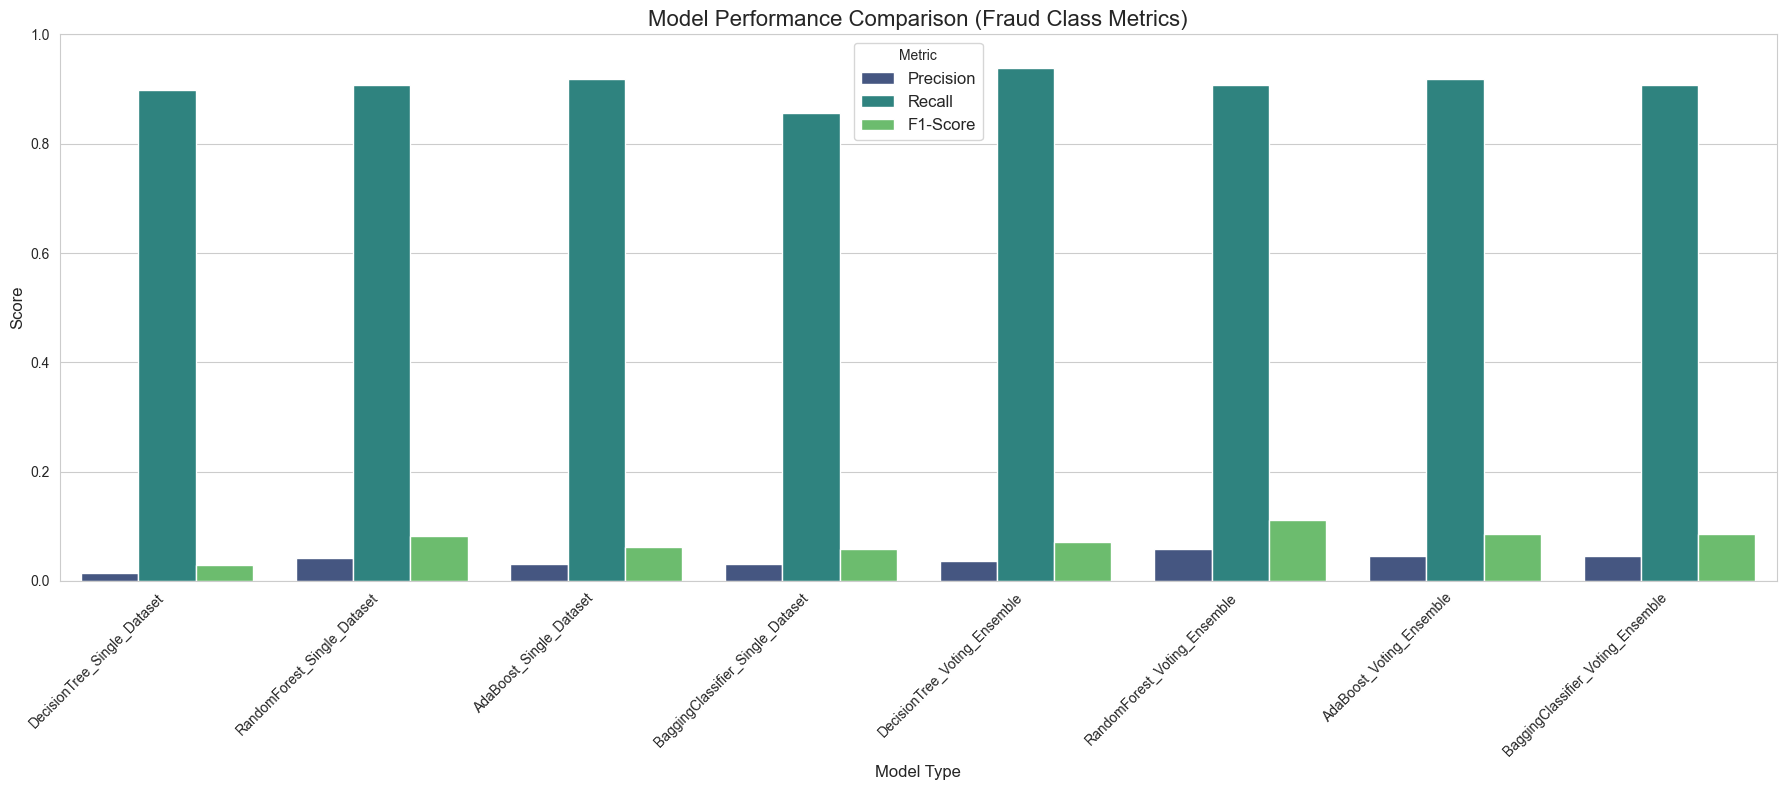

In [65]:
# Create a DataFrame for easy plotting
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Melt the DataFrame to a long format for Seaborn
results_melted = results_df.melt(id_vars='Model', value_vars=['Precision', 'Recall', 'F1-Score'],
                                 var_name='Metric', value_name='Score')

# --- VISUALIZATION ---
plt.figure(figsize=(18, 8))
sns.barplot(x='Model', y='Score', hue='Metric', data=results_melted, palette='viridis')
plt.title('Model Performance Comparison (Fraud Class Metrics)', fontsize=16)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Model Type', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.0)
plt.legend(title='Metric', fontsize=12)
plt.tight_layout()
plt.show()
